In [460]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import datetime
from scipy import stats
from math import sqrt
import math,os

In [461]:
#录入path路径下所有的'.npy'结尾的文件
path = 'C:/Users/Administrator/Documents'

#获取所有path下所有文件
dirs = os.listdir(path)
data = {}
#开始录入
for x in dirs:
    #如果以.npy结尾则录入
    if os.path.splitext(x)[1]=='.npy':
        name = os.path.splitext(x)[0]
        file = path+'\\'+x
        value = np.load(file)
        data[name]=value
        
#展示录入的所有文件
data.keys()

dict_keys(['AdjFactor', 'BPS', 'BSQ0_TOT_ASSETS', 'CAPQ0_FLOAT_A', 'CAPQ0_FLOAT_A_SHR', 'ClosePrice', 'ClosePrice_index', 'dates', 'EPS_BASIC', 'EPS_dates', 'EPS_ticker_names', 'fd_dates', 'fd_tic', 'FIQ0_S_FA_BPS', 'FIQ0_S_FA_ROE', 'HighestPrice', 'index_ClosePrice', 'index_ticker_names', 'l2_dates', 'l2_ticker_names', 'LowestPrice', 'OpenPrice', 'PRC', 'S_LI_INITIATIVEBUYRATE', 'S_LI_INITIATIVESELLRATE', 'ticker_names', 'ticker_names_index', 'ticker_names_wind', 'TradeStatus', 'TradingDays', 'Turnover', 'Volume', 'VWAP', 'WIND_IDX_INDCLS2_MEMBER', 'WIND_INDCLS_MEMBER'])

In [462]:
#录入path路径下所有的'.npy'结尾的文件
path = 'C:/Users/Administrator/Documents/COP'

#获取所有path下所有文件
dirs = os.listdir(path)
cop_data = {}
#开始录入
for x in dirs:
    #如果以.npy结尾则录入
    if os.path.splitext(x)[1]=='.xlsx':
        name = os.path.splitext(x)[0]
        file = path+'\\'+x
        value = pd.read_excel(file)
        cop_data[name]=value
        
#展示录入的所有文件
cop_data.keys()

dict_keys(['account_payables', 'account_receivables', 'deferred_revenue_current', 'deferred_revenue_noncurrent', 'inventory', 'operating_income', 'other_expense', 'prepaid', 'R_D_expense'])

In [463]:
#原始数据处理
for i in cop_data.keys():
    cop_data[i]['证券代码'] = cop_data[i]['证券代码'].apply(lambda x: x[:6])
    cop_data[i].index = cop_data[i]['证券代码'].values
    cop_data[i].drop(['证券简称','证券代码'],axis=1,inplace=True)
    cop_data[i].columns = list(range(2000,2021))
    cop_data[i] = cop_data[i].T

In [464]:
#处理得到净值变化
for i in  ['account_payables', 'account_receivables', 'deferred_revenue_current', 'deferred_revenue_noncurrent', 'inventory',
           'other_expense', 'prepaid',]:
    cop_data[i].iloc[:,:] = np.diff(cop_data[i],1,axis=0,prepend=np.nan)
    cop_data[i].fillna(0,inplace=True)
cop_data['R_D_expense'].fillna(0,inplace=True)

In [465]:
#读取其他数据
tic = data['ticker_names']
dates = pd.to_datetime(data['dates'])
fd_dates = pd.to_datetime(data['fd_dates'])
fd_tick = data['fd_tic']

#统一tic universe
tics = (set(fd_tick)&set(cop_data['operating_income'].columns)&set(tic))

#读取和fama因子模型相关的市值，BP，ROE，资产回报率
ClosePrice = pd.DataFrame(data['ClosePrice'],index = tic,columns=dates).T[tics]
MarketCap = pd.DataFrame(data['CAPQ0_FLOAT_A'],index = tic,columns=dates).T[tics]
BPS = pd.DataFrame(data['FIQ0_S_FA_BPS'].T,index = fd_dates,columns=fd_tick)[tics]
TotalAsset = pd.DataFrame(data['BSQ0_TOT_ASSETS'].T,index = fd_dates,columns=fd_tick)[tics]
ROE = pd.DataFrame(data['FIQ0_S_FA_ROE'].T,index = fd_dates,columns=fd_tick)[tics]


In [466]:
#对fama5因子相关数据进行数据处理，获得SMB HML RMW CMA的原始对应数据
TotalAsset = TotalAsset.resample('Q').last()
ROE = ROE.resample('Q').last()
BPS = BPS.resample('Q').last()
MC = MarketCap.resample('Q').last()
TotalAsset = TotalAsset.resample('Q').last()

def june_data(df):
    for i in df.index:
        if i.month != 6:
            df.drop(i,axis=0,inplace=True)
    return(df)

TotalAsset = june_data(TotalAsset)
ROE = june_data(ROE)
BPS = june_data(BPS)
MC = june_data(MC)
AR = np.log(TotalAsset)-np.log(TotalAsset.shift(1))
AR[abs(AR)==np.inf]=np.nan

<ipython-input-466-3cad21c5198c>:18: RuntimeWarning: divide by zero encountered in log
  AR = np.log(TotalAsset)-np.log(TotalAsset.shift(1))


In [467]:
#获取COP因子值：
non_scaled = (cop_data['operating_income']+cop_data['R_D_expense']-cop_data['account_receivables']-cop_data['inventory']-cop_data['prepaid']+cop_data['deferred_revenue_current']+cop_data['deferred_revenue_noncurrent']+cop_data['account_payables']+cop_data['other_expense'])[tics]
non_scaled.index = TotalAsset.index[9:-1]

#除以年末总资产
COP = non_scaled / TotalAsset.loc[non_scaled.index,tics]
COP[abs(COP)==np.inf] = np.nan

COP.tail()

003033    688160    603606    300278    002330    600439  \
2016-06-30  0.123794  0.148165  0.022061 -0.046776  0.015192  0.090701   
2017-06-30  0.228186  0.301636 -0.202164 -0.065883 -0.018712  0.040645   
2018-06-30  0.251153  0.321572  0.099975  0.064998 -0.027334 -0.041856   
2019-06-30  0.318764  0.380250  0.114728 -0.071959  0.016176  0.032556   
2020-06-30  0.237294  0.668689  0.104047 -0.069639  0.033845  0.042219   

              300017    002076    300080    002590  ...    000042    600030  \
2016-06-30  0.113916 -0.026517 -0.036055  0.032934  ... -0.076925  0.024294   
2017-06-30  0.113220 -0.272613 -0.074618  0.039127  ... -0.202052  0.026015   
2018-06-30  0.113339 -0.168884  0.147826  0.013990  ...  0.079363  0.018245   
2019-06-30  0.055012  0.078806  0.168564  0.104305  ... -0.078040  0.025263   
2020-06-30  0.073959  0.005681  0.061417  0.062218  ...  0.057485  0.022376   

              601700    300558  300919    600495    002189    002893  \
2016-06-30 -0.019039  1.590626     NaN -0.009218  0.015888  0.038171   
2017-06-30  0.083701  0.107778     NaN  0.062174  0.092596  0.069102   
2018-06-30  0.009944  0.200532     NaN  0.063569  0.016897  0.074351   
2019-06-30 -0.085415  0.128198     NaN  0.083834  0.101376  0.060047   
2020-06-30  0.158219  0.231353     NaN  0.030316  0.042498  0.024645   

              600990    000581  
2016-06-30  0.070431  0.100955  
2017-06-30 -0.061780  0.153197  
2018-06-30  0.057245  0.121780  
2019-06-30  0.016863  0.119866  
2020-06-30 -0.064669  0.148510  

[5 rows x 4232 columns]

In [468]:
#对数据进行中心化和标准化处理，去除极端值，这不改变每期的大小排序
def normalization(data,ax=1):
    def centrilization(x):
        y=abs(x-x.median()).median()*5
        x[x>(x.median()+y)]=x.median()+y
        x[x<(x.median()-y)]=x.median()-y
        return(x)
    data=data.apply(centrilization,axis=ax)
    data=data.apply(lambda x: (x-x.mean())/x.std(),axis=ax)
    return(data)

COP = normalization(COP,ax=0)
COP.tail()

003033    688160    603606    300278    002330    600439  \
2016-06-30 -1.413831 -1.210188 -0.036409  0.085374  0.109890  1.440914   
2017-06-30 -0.202443 -0.304864 -1.842809 -0.244360 -1.048241  0.687893   
2018-06-30  0.259817 -0.187262  0.657294  1.404311 -1.342775 -0.553210   
2019-06-30  1.375582  0.158878  0.788643 -0.349208  0.143534  0.566209   
2020-06-30 -0.019125  1.543436  0.693543 -0.309180  0.747080  0.711581   

              300017    002076    300080    002590  ...    000042    600030  \
2016-06-30 -0.203580 -0.207034  0.030356 -0.222069  ... -0.267573 -0.765442   
2017-06-30 -0.210756 -1.686890 -0.229831  0.025945  ... -1.044550 -0.710614   
2018-06-30 -0.209530 -1.686890  1.271042 -0.980774  ...  0.702892 -0.958239   
2019-06-30 -0.811722  1.252285  1.410968  2.341665  ... -0.274497 -0.734564   
2020-06-30 -0.616102  0.239083  0.688024  0.950730  ...  0.567041 -0.826572   

              601700    300558  300919    600495    002189    002893  \
2016-06-30 -0.490776  1.062226     NaN -0.398976  0.051418 -0.713756   
2017-06-30  0.866369 -0.957931     NaN  0.575631  1.601283  0.749097   
2018-06-30 -0.107924 -0.705212     NaN  0.594665  0.071802  0.997299   
2019-06-30 -1.367568 -0.902295     NaN  0.871323  1.778689  0.320827   
2020-06-30  1.850719 -0.621238     NaN  0.140726  0.589062 -1.353466   

              600990    000581  
2016-06-30  0.802087 -0.167040  
2017-06-30 -0.741039  1.180838  
2018-06-30  0.648187  0.370264  
2019-06-30  0.176858  0.320877  
2020-06-30 -0.774758  1.059911  

[5 rows x 4232 columns]

mean                    -4.7274e-18
median                  -0.00805475
max                         3.32154
min                        -3.41024
std                        0.957102
skewness     [0.025678435128306237]
kurtosis    [-0.035507991051956456]
dtype: object


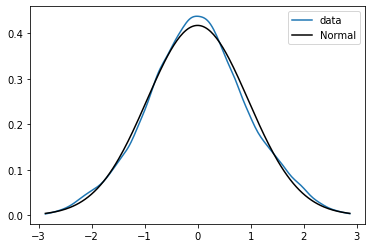

In [469]:
#描述性统计量(对观察期内全部样本数据)
def statistics(close):
    
    mc = np.mean(close)
    stdc = np.std(close)
    print(pd.Series({'mean':mc,'median':np.median(close),'max':np.max(close),'min':np.min(close),'std':stdc,'skewness':stats.skew(close.T),'kurtosis':stats.kurtosis(close.T)}))
    
    #distribution plot
    x = np.linspace(mc-3*stdc,mc+3*stdc,200)
    y = stats.norm.pdf(x,mc,stdc)
    kde = stats.gaussian_kde(close)
    plt.plot(x,kde(x),label='data')
    plt.plot(x,y,color='black',label='Normal')
    plt.legend()
    plt.show()
    
statistics(np.hstack([COP.loc[k,:].dropna().values.reshape(1,-1) for k in COP.index]))

In [470]:
#对price取log return
ClosePrice = ClosePrice.resample('Q').last()
ClosePrice = june_data(ClosePrice)
Re = np.log(ClosePrice.shift(-1)) - np.log(ClosePrice)
Re.tail()

003033  688160    603606    300278    002330    600439    300017  \
2017-06-30     NaN     NaN -0.174579 -0.603828 -0.507430 -0.421282 -0.116949   
2018-06-30     NaN     NaN  0.424606 -0.438531  0.076336 -0.167768  0.008839   
2019-06-30     NaN     NaN  0.526310 -0.502315  0.224541 -0.058922 -0.234945   
2020-06-30     NaN     NaN  0.466386 -0.113555 -0.214106 -0.138444 -0.279471   
2021-06-30     NaN     NaN       NaN       NaN       NaN       NaN       NaN   

              002076    300080    002590  ...    000042    600030    601700  \
2017-06-30 -0.410428 -0.462321 -0.531186  ... -0.100599 -0.006188 -0.548823   
2018-06-30 -0.407600  0.202524 -0.018462  ... -0.391041  0.387389  0.612624   
2019-06-30 -0.163273 -0.287682 -0.153195  ...  0.013007  0.027909 -0.138273   
2020-06-30 -0.256720 -0.006689 -0.076256  ... -0.121454  0.016588 -0.077037   
2021-06-30       NaN       NaN       NaN  ...       NaN       NaN       NaN   

              300558  300919    600495    002189    002893    600990    000581  
2017-06-30 -0.066523     NaN -0.607555 -0.242340       NaN -0.226168 -0.134965  
2018-06-30 -0.291120     NaN  0.215320  0.554910 -0.250816 -0.054607 -0.057599  
2019-06-30  1.217611     NaN -0.210565 -0.271686 -0.172875 -0.158531  0.159427  
2020-06-30 -0.314079     NaN  0.027733 -0.034922  0.114776  0.136083  0.140519  
2021-06-30       NaN     NaN       NaN       NaN       NaN       NaN       NaN  

[5 rows x 4232 columns]

In [471]:
#获取上证指数年度return
market_index = pd.DataFrame(data['index_ClosePrice'],index=data['index_ticker_names'],columns=pd.to_datetime(data['EPS_dates'])).T['000001']
market_index = market_index.resample('Q').last()
market_index = june_data(market_index)
market_index_return = np.log(market_index.shift(-1))-np.log(market_index)
market_index_return.tail()

2017-06-30   -0.114369
2018-06-30    0.045134
2019-06-30    0.001944
2020-06-30    0.142320
2021-06-30         NaN
Name: 000001, dtype: float64

In [472]:
#获取SMB HML RMW CMA各组收益
smb = []
hml = []
rmw = []
cma = []

ob_d = COP.index

def fama_groups(df,g=3):
    label = list(range(g))
    fama_sort = pd.qcut(df.dropna(),g,labels=label)

    big = fama_sort[fama_sort==label[-1]].index
    small = fama_sort[fama_sort==label[0]].index
    return(big,small)

for i in ob_d:
    h,l = fama_groups(MC.loc[i,:])
    b,s = fama_groups(BPS.loc[i,:])
    w,r = fama_groups(ROE.loc[i,:])
    c,a = fama_groups(TotalAsset.loc[i,:],2)
    
    hml.append(Re.loc[i,h].mean()-Re.loc[i,l].mean())
    smb.append(Re.loc[i,s].mean()-Re.loc[i,b].mean())
    rmw.append(Re.loc[i,r].mean()-Re.loc[i,w].mean())
    cma.append(Re.loc[i,c].mean()-Re.loc[i,a].mean())
    
hml = pd.Series(hml,index=ob_d)
smb = pd.Series(smb,index=ob_d)
rmw = pd.Series(rmw,index=ob_d)
cma = pd.Series(cma,index=ob_d)

In [473]:
#去除金融行业的数据 #882115 882116 882117
#获取wind行业分类
ind = pd.DataFrame(data['WIND_IDX_INDCLS2_MEMBER'],index=tic,columns=dates).T[tics]
ind= ind.resample('y').last()
ind

003033  688160  603606  300278  002330  600439  300017  002076  \
1990-12-31       0       0       0       0       0       0       0       0   
1991-12-31       0       0       0       0       0       0       0       0   
1992-12-31       0       0       0       0       0       0       0       0   
1993-12-31       0       0       0       0       0       0       0       0   
1994-12-31       0       0       0       0       0       0       0       0   
1995-12-31       0       0       0       0       0       0       0       0   
1996-12-31       0       0       0       0       0       0       0       0   
1997-12-31       0       0       0       0       0       0       0       0   
1998-12-31       0       0       0       0       0       0       0       0   
1999-12-31       0       0       0       0       0       0       0       0   
2000-12-31       0       0       0       0       0       0       0       0   
2001-12-31       0       0       0       0       0       0       0       0   
2002-12-31       0       0       0       0       0       0       0       0   
2003-12-31       0       0       0       0       0  882112       0       0   
2004-12-31       0       0       0       0       0  882112       0       0   
2005-12-31       0       0       0       0       0  882112       0       0   
2006-12-31       0       0       0       0       0  882112       0  882106   
2007-12-31       0       0       0       0       0  882112       0  882106   
2008-12-31       0       0       0       0       0  882112       0  882106   
2009-12-31       0       0       0       0       0  882112  882119  882106   
2010-12-31       0       0       0       0  882111  882112  882119  882106   
2011-12-31       0       0       0  882102  882111  882112  882119  882106   
2012-12-31       0       0       0  882102  882111  882112  882119  882106   
2013-12-31       0       0       0  882102  882111  882112  882119  882106   
2014-12-31       0       0  882102  882102  882111  882112  882119  882106   
2015-12-31       0       0  882102  882102  882111  882112  882119  882106   
2016-12-31       0       0  882102  882102  882111  882112  882119  882106   
2017-12-31       0       0  882102  882102  882111  882112  882119  882106   
2018-12-31       0       0  882102  882102  882111  882112  882119  882106   
2019-12-31       0       0  882102  882102  882111  882112  882119  882106   
2020-12-31       0  882102  882102  882102  882111  882112  882119  882106   
2021-12-31  882105  882102  882102  882102  882111  882112  882119  882106   

            300080  002590  ...  000042  600030  601700  300558  300919  \
1990-12-31       0       0  ...       0       0       0       0       0   
1991-12-31       0       0  ...       0       0       0       0       0   
1992-12-31       0       0  ...       0       0       0       0       0   
1993-12-31       0       0  ...       0       0       0       0       0   
1994-12-31       0       0  ...  882118       0       0       0       0   
1995-12-31       0       0  ...  882118       0       0       0       0   
1996-12-31       0       0  ...  882118       0       0       0       0   
1997-12-31       0       0  ...  882118       0       0       0       0   
1998-12-31       0       0  ...  882118       0       0       0       0   
1999-12-31       0       0  ...  882118       0       0       0       0   
2000-12-31       0       0  ...  882118       0       0       0       0   
2001-12-31       0       0  ...  882118       0       0       0       0   
2002-12-31       0       0  ...  882118       0       0       0       0   
2003-12-31       0       0  ...  882118  882116       0       0       0   
2004-12-31       0       0  ...  882118  882116       0       0       0   
2005-12-31       0       0  ...  882118  882116       0       0       0   
2006-12-31       0       0  ...  882118  882116       0       0       0   
2007-12-31       0       0  ...  882118  882116       0       0       0   
2008-12-31  

In [474]:
dropindex = []
for i in ind.columns:
    if (882115 == ind.loc[:,i]).sum()>0 or (882116 == ind.loc[:,i]).sum()>0 or (882117 == ind.loc[:,i]).sum()>0 :
        dropindex.append(i)
len(dropindex)

124

In [475]:
drop_finance = set(tics)-set(dropindex)

In [476]:
#创建分析类
class factor_analysis(object):
    def __init__(self, factors):
        self.factors = factors
    
    #等值加权
    def E_weight(self,ob_t,tt='cvd'):
        ew_re = pd.DataFrame(None,index=ob_t,columns=list(range(10)))
        for i in self.factors.index:
            selected = self.Re.loc[i,:].dropna().index
            groups = pd.qcut(self.factors.loc[i,selected],10,labels=list(range(10)))
            ew_re.loc[i,:] = self.Re.loc[i,groups.index].groupby(by=groups).mean()

        #多空组合
        ew_re['h-l'] = ew_re[9]-ew_re[0]
        
        #cumulative return
        ew_re_cum = ew_re.cumsum()

        #plot
        plt.figure(figsize=(20,24))
        plt.subplot(211)
        for i in range(10):
            plt.plot(ew_re[i],label='group'+str(i))
        plt.plot(ew_re['h-l'],label='group h-l')
        plt.title('equal_weighted_log_return_'+tt)
        plt.legend()

        plt.subplot(212)
        for i in range(10):
            plt.plot(ew_re_cum[i],label='group'+str(i))
        plt.plot(ew_re_cum['h-l'],label='group h-l')
        plt.title('equal_weighted_cumulative_log_return_'+tt)
        plt.legend()
        
        m = np.exp(ew_re_cum.iloc[-1,:].mean())
        def evaluate(df1,rf=0.0384,n=20):
            df1 = df1.astype('float')
            
            #CAPM
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            capm_alpha = beta[0][0,0]
            capm_beta = beta[1][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_capm = beta.T/se
            
            #fama 3-factor
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama3_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama3 = beta.T/se
            
            #fama 5-factor
            
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t],rmw[ob_t],cma[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama5_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama5 = beta.T/se
            
            df = df1.cumsum()
            df = np.exp(df.astype('float'))
            Maxdrawdown = -round(((df-df.expanding().max())/df.expanding().max()).min(),3)
            alpha = (df[-1]-m)/n
            sr = round((df[-1]-1-rf*n)/(df.std()*12**0.5),3)
            return(pd.Series({'TotalReturn':round(df[-1]-1,4),'AnnualReturn':round(df[-1]**(1/n)-1,4),'Sharpe':sr,
                              'CAPM Alpha':[round(capm_alpha,4),round(t_value_capm[0,0],4)],'Beta':[round(capm_beta,4),round(t_value_capm[0,1],4)]
                              ,'fama-3-factor alpha':[round(fama3_alpha,4),round(t_value_fama3[0,0],4)]
                              ,'fama-5-factor alpha':[round(fama5_alpha,4),round(t_value_fama5[0,0],4)],'Maxdrawdown':Maxdrawdown}))
        return(ew_re.apply(evaluate,axis=0).T)
    
    #市值加权
    def MC_weight(self,ob_t,tt='cvd'):
        mw_re = pd.DataFrame(None,index=ob_t,columns=list(range(10)))

        #收益率乘以市值再分组加总后，除以各组市值加总即为各组市值加权平均收益，这一方法在迭代上具有优势
        mw = self.Re*self.MarketCap

        for i in self.factors.index:
            selected = self.Re.loc[i,:].dropna().index
            groups = pd.qcut(self.factors.loc[i,selected],10,labels=list(range(10)))
            mw_re.loc[i,:] = mw.loc[i,groups.index].groupby(by=groups).sum()/self.MarketCap.loc[i,groups.index].groupby(by=groups).sum()

        #多空组合
        mw_re['h-l'] = mw_re[9]-mw_re[0]
        
        #cumulative return
        mw_re_cum = mw_re.cumsum()

        #plot
        plt.figure(figsize=(20,24))
        plt.subplot(211)
        for i in range(10):
            plt.plot(mw_re[i],label='group'+str(i))
        plt.plot(mw_re['h-l'],label='group h-l')
        plt.title('MarketCap_weighted_log_return_'+tt)
        plt.legend()

        plt.subplot(212)
        for i in range(10):
            plt.plot(mw_re_cum[i],label='group'+str(i))
        plt.plot(mw_re_cum['h-l'],label='group h-l')
        plt.title('MarketCap_weighted_cumulative_log_return_'+tt)
        plt.legend()
        
        m = np.exp(mw_re_cum.iloc[-1,:].mean())
        def evaluate(df1,rf=0.0384,n=20):
            df1 = df1.astype('float')
            
            #CAPM
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            capm_alpha = beta[0][0,0]
            capm_beta = beta[1][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_capm = beta.T/se
            
            #fama 3-factor
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama3_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama3 = beta.T/se
            
            #fama 5-factor
            
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t],rmw[ob_t],cma[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama5_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama5 = beta.T/se
            
            df = df1.cumsum()
            df = np.exp(df.astype('float'))
            Maxdrawdown = -round(((df-df.expanding().max())/df.expanding().max()).min(),3)
            alpha = (df[-1]-m)/n
            sr = round((df[-1]-1-rf*n)/(df.std()*12**0.5),3)
            return(pd.Series({'TotalReturn':round(df[-1]-1,4),'AnnualReturn':round(df[-1]**(1/n)-1,4),'Sharpe':sr,
                              'CAPM Alpha':[round(capm_alpha,4),round(t_value_capm[0,0],4)],'Beta':[round(capm_beta,4),round(t_value_capm[0,1],4)]
                              ,'fama-3-factor alpha':[round(fama3_alpha,4),round(t_value_fama3[0,0],4)]
                              ,'fama-5-factor alpha':[round(fama5_alpha,4),round(t_value_fama5[0,0],4)],'Maxdrawdown':Maxdrawdown}))

        return(mw_re.apply(evaluate,axis=0).T)


TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.2021       0.0092 -0.226   [-0.0214, -0.631]   [1.0921, 10.0026]   
1        0.3741        0.016 -0.183  [-0.0133, -0.4185]   [1.0301, 10.0647]   
2        0.8671       0.0317  0.035    [0.0012, 0.0388]   [1.0346, 10.4293]   
3        0.5957       0.0236  -0.08  [-0.0069, -0.2127]   [1.0581, 10.0622]   
4        0.8067         0.03  0.015  [-0.0009, -0.0267]    [1.052, 10.2386]   
5        0.9892        0.035  0.077    [0.0044, 0.1423]   [1.0292, 10.4177]   
6        1.5556        0.048  0.229    [0.0159, 0.5208]     [1.042, 10.559]   
7        2.0135       0.0567  0.311     [0.024, 0.7928]   [1.0335, 10.5763]   
8        1.7862       0.0526  0.292    [0.0205, 0.7269]   [1.0253, 11.2649]   
9        2.5132       0.0648  0.407    [0.0326, 1.2076]   [0.9878, 11.3506]   
h-l      1.9226       0.0551   0.69    [0.0539, 3.1886]  [-0.1043, -1.9112]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0893, -3.4662]  [-0.0516, -1.5798]       0.719  
1     [-0.084, -3.4353]  [-0.0408, -1.3803]       0.715  
2    [-0.0596, -2.4127]  [-0.0092, -0.3309]       0.684  
3    [-0.0719, -2.7687]   [-0.0222, -0.742]        0.75  
4     [-0.0598, -2.459]   [-0.015, -0.5204]       0.716  
5    [-0.0518, -1.9533]     [0.006, 0.2067]       0.694  
6     [-0.042, -1.8353]    [0.0043, 0.1658]       0.715  
7    [-0.0351, -1.3923]    [0.0097, 0.3192]       0.667  
8    [-0.0437, -2.1028]    [0.0032, 0.1432]       0.673  
9    [-0.0247, -0.9429]    [0.0224, 0.7449]       0.604  
h-l    [0.0646, 3.5462]    [0.0741, 3.0668]       0.085

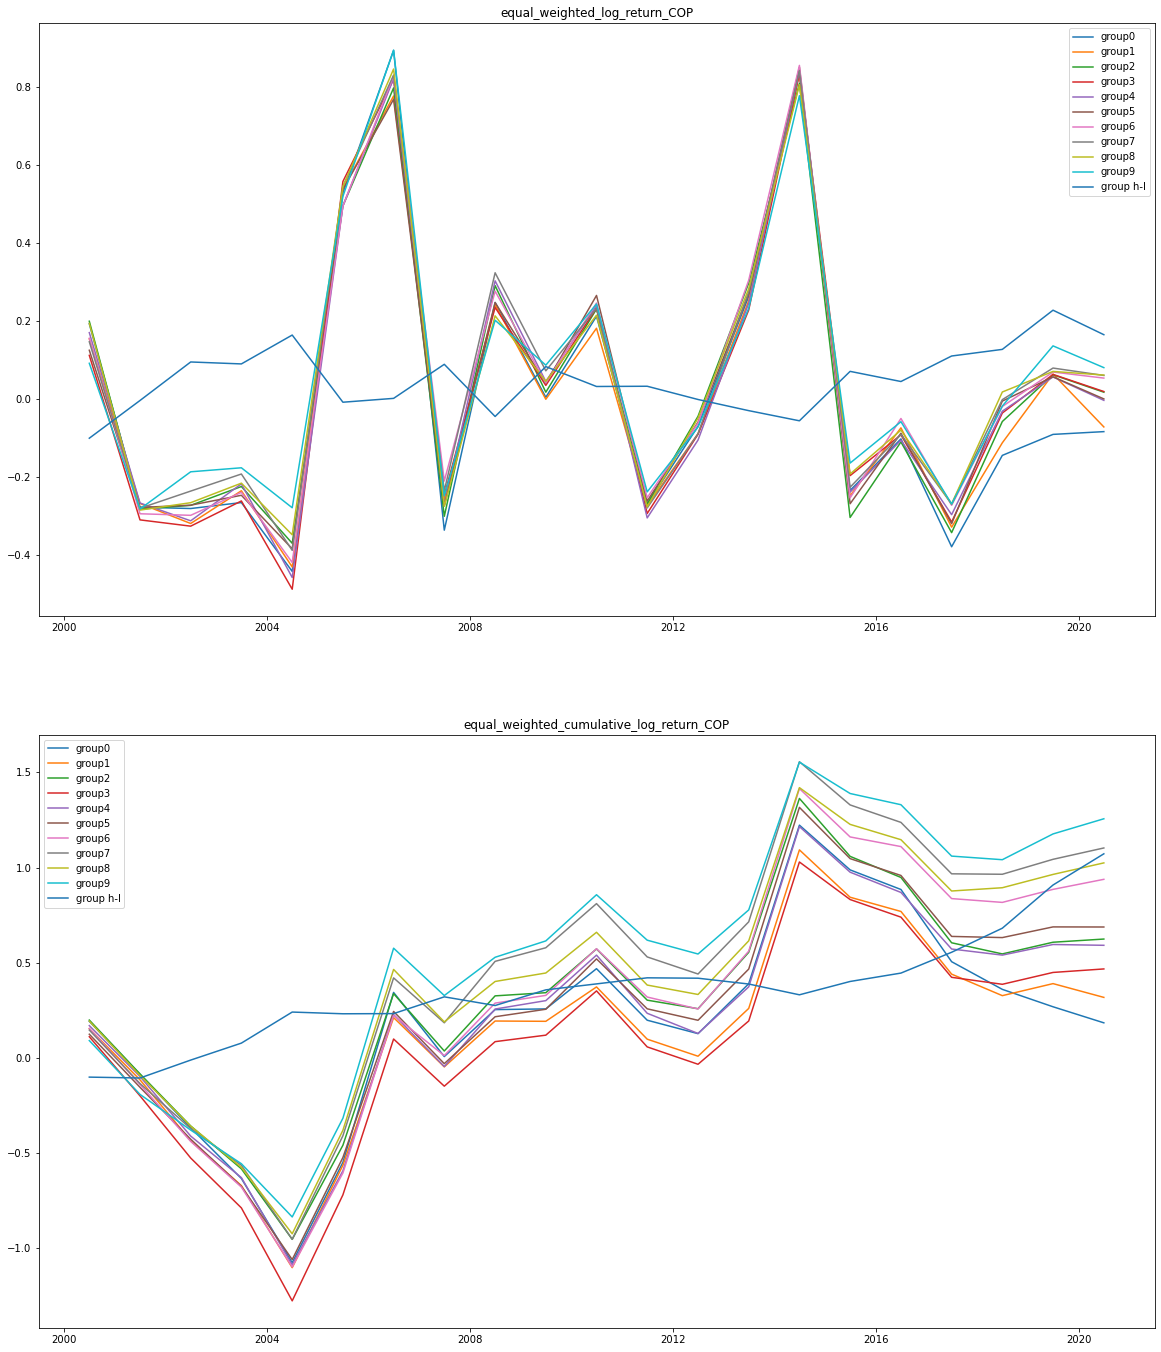

In [477]:
#传入参数
cvd_ana = factor_analysis(COP[drop_finance])
cvd_ana.Re = Re[drop_finance]
cvd_ana.MarketCap = MC[drop_finance]

#等值加权
cvd_ana.E_weight(ob_t = COP.index,tt='COP')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        -0.485      -0.0326 -1.212   [-0.0636, -2.582]     [1.16, 14.6015]   
1       -0.2861      -0.0167 -1.114  [-0.0463, -3.3057]   [1.0963, 24.2767]   
2        0.0645       0.0031 -0.583   [-0.0276, -1.794]    [1.1074, 22.342]   
3       -0.2107      -0.0118 -1.176  [-0.0401, -1.7182]   [1.0445, 13.8832]   
4        0.1725        0.008  -0.55  [-0.0215, -1.1966]   [1.0557, 18.1816]   
5        0.3117       0.0137 -0.398  [-0.0163, -1.0487]   [1.0594, 21.1304]   
6        1.0493       0.0365   0.16    [0.0059, 0.2751]   [1.0237, 14.7304]   
7        0.4456       0.0186 -0.251  [-0.0112, -0.6583]    [1.0433, 18.961]   
8        0.5918       0.0235 -0.128  [-0.0062, -0.4041]   [1.0276, 20.7359]   
9         0.772        0.029  0.003       [0.0, 0.0017]   [0.9862, 13.4205]   
h-l      2.4411       0.0637  0.822    [0.0636, 2.4125]  [-0.1738, -2.0426]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0948, -3.2536]  [-0.0711, -1.7958]       0.724  
1    [-0.0659, -4.1119]   [-0.0633, -2.852]       0.668  
2     [-0.0387, -1.931]  [-0.0169, -0.6349]       0.644  
3    [-0.0666, -2.2184]  [-0.0238, -0.6467]       0.722  
4    [-0.0381, -1.7943]  [-0.0186, -0.6892]       0.658  
5    [-0.0247, -1.1619]    [0.0071, 0.2684]       0.629  
6    [-0.0049, -0.1732]     [0.045, 1.3067]       0.679  
7    [-0.0246, -1.1162]    [0.0063, 0.2298]       0.609  
8     [-0.032, -1.9052]   [-0.009, -0.4175]       0.638  
9    [-0.0282, -0.9531]     [0.0139, 0.413]         0.6  
h-l    [0.0666, 2.0082]     [0.085, 1.9934]       0.207

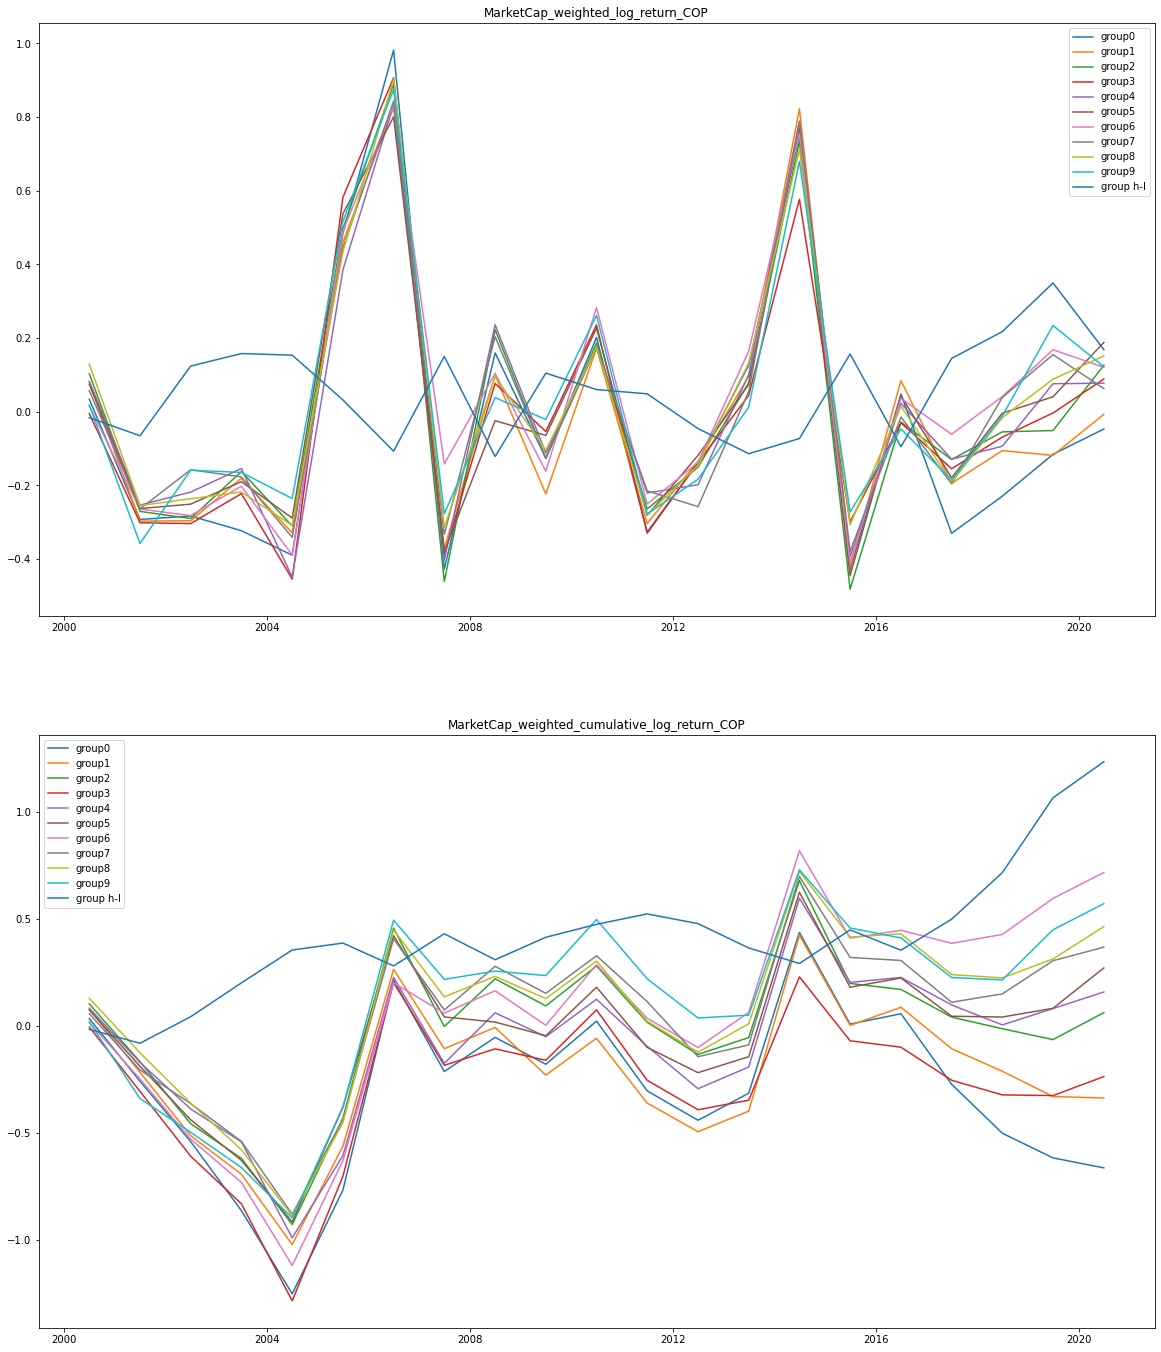

In [478]:
#市值加权
cvd_ana.MC_weight(ob_t = COP.index,tt='COP')

In [479]:
ind.iloc[10,:].value_counts()

0         3281
882101     199
882102     161
882106      88
882109      72
882111      68
882118      54
882120      53
882114      48
882105      47
882123      38
882104      33
882100      22
882107      22
882113       9
882110       8
882103       6
882116       5
882121       4
882112       4
882115       3
882108       3
882119       3
882122       1
Name: 2000-12-31 00:00:00, dtype: int64

In [480]:
#我们选取wind行业标码为 882106(耐用消费品与服装) 882114(制药，生命科技与生物科学) 882109（零售业) 行业
ind_882106 = ind.iloc[-1,:][ind.iloc[-1,:]==882106].index & tics
ind_882114 = ind.iloc[-1,:][ind.iloc[-1,:]==882114].index & tics
ind_882109 = ind.iloc[-1,:][ind.iloc[-1,:]==882109].index & tics

In [481]:
#传入数据
ind_882106_test = factor_analysis(COP.loc[:,ind_882106])
ind_882106_test.Re = Re.loc[:,ind_882106]
ind_882106_test.MarketCap = MC

ind_882114_test = factor_analysis(COP.loc[:,ind_882114])
ind_882114_test.Re = Re.loc[:,ind_882114]
ind_882114_test.MarketCap = MC

ind_882109_test = factor_analysis(COP.loc[:,ind_882109])
ind_882109_test.Re = Re.loc[:,ind_882109]
ind_882109_test.MarketCap = MC


TotalReturn AnnualReturn Sharpe          CAPM Alpha              Beta  \
0       -0.2358      -0.0134 -0.446  [-0.0377, -0.8267]  [0.9026, 6.1364]   
1        0.1712       0.0079 -0.333  [-0.0196, -0.5599]  [0.9827, 8.7116]   
2       -0.1716      -0.0094 -0.665   [-0.0421, -1.086]  [1.2029, 9.6108]   
3        1.4205       0.0452  0.171    [0.0113, 0.2674]  [1.1158, 8.1761]   
4        0.4138       0.0175 -0.113   [-0.0138, -0.319]   [1.0972, 7.879]   
5        0.8128       0.0302  0.016    [0.0008, 0.0192]  [0.9967, 7.0995]   
6         1.211       0.0405  0.127     [0.009, 0.2105]  [1.0441, 7.5901]   
7        0.6452       0.0252 -0.056  [-0.0023, -0.0544]   [0.944, 6.8314]   
8         3.367       0.0765  0.466     [0.045, 0.8325]  [0.9147, 5.2517]   
9        1.3213        0.043  0.182     [0.008, 0.1865]  [1.1637, 8.4071]   
h-l      2.0375       0.0571  0.685     [0.0457, 1.262]  [0.2611, 2.2355]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.1357, -3.0201]  [-0.0939, -1.5571]       0.729  
1    [-0.0699, -2.2547]  [-0.0444, -1.1037]       0.653  
2    [-0.1077, -3.2732]  [-0.0742, -1.9097]       0.805  
3    [-0.0702, -1.9297]  [-0.0469, -0.9635]       0.768  
4    [-0.0896, -2.6199]  [-0.0506, -1.2365]       0.749  
5     [-0.099, -2.1302]  [-0.0423, -0.6995]       0.561  
6    [-0.0584, -1.7037]  [-0.0419, -0.8921]       0.757  
7     [-0.0993, -2.685]  [-0.0584, -1.2393]       0.728  
8    [-0.0309, -0.5867]    [0.0041, 0.0565]         0.8  
9      [-0.061, -1.522]  [-0.0732, -1.3256]       0.741  
h-l    [0.0747, 1.5676]    [0.0208, 0.3371]       0.532

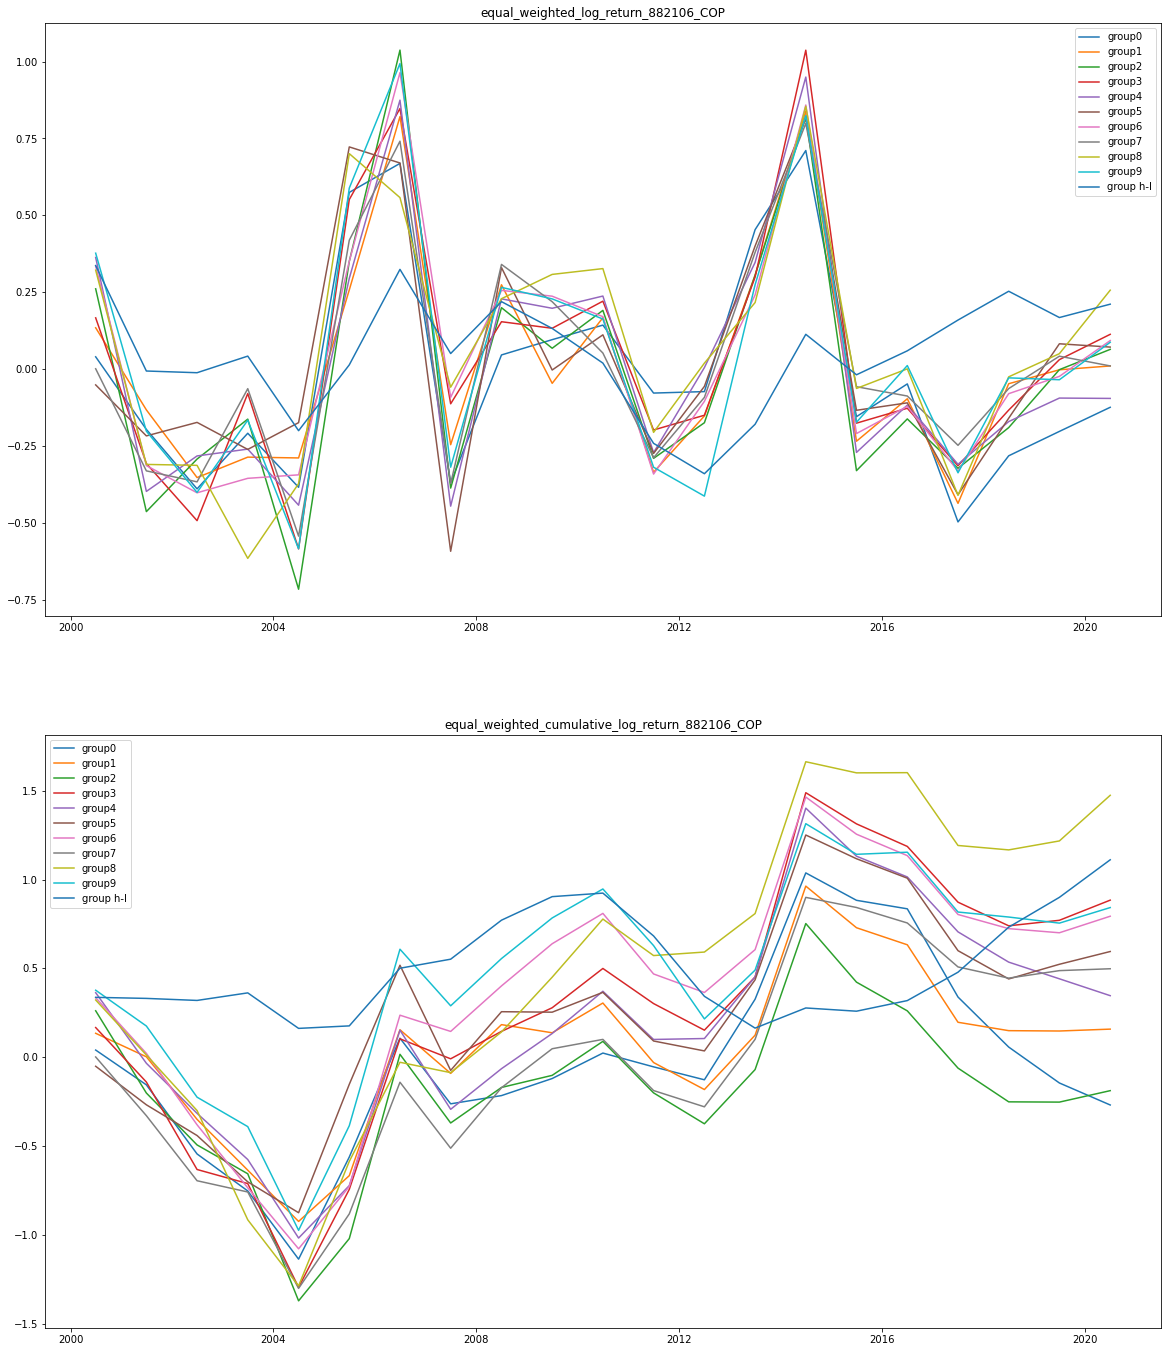

In [482]:
#882106 等值加权
ind_882106_test.E_weight(ob_t = COP.index,tt='882106_COP')

TotalReturn AnnualReturn Sharpe          CAPM Alpha               Beta  \
0       -0.2754       -0.016  -0.49  [-0.0386, -0.8143]   [0.8443, 5.5188]   
1        0.9367       0.0336  0.076    [0.0059, 0.1501]   [0.9265, 7.2859]   
2       -0.4822      -0.0324 -1.215  [-0.0708, -1.3424]   [1.4315, 8.4123]   
3        1.6255       0.0494  0.221     [0.012, 0.3448]  [1.2318, 10.9836]   
4        -0.557      -0.0399 -1.649  [-0.0707, -1.5782]   [1.1591, 8.0181]   
5         1.365        0.044  0.191    [0.0148, 0.3091]   [0.9478, 6.1193]   
6          1.06       0.0368  0.142    [0.0047, 0.1288]   [1.0766, 9.1118]   
7        0.8358       0.0308   0.03    [0.0075, 0.1707]   [0.7776, 5.5061]   
8        1.2666       0.0418  0.226    [0.0115, 0.2306]   [0.9952, 6.1794]   
9         0.379       0.0162 -0.269  [-0.0155, -0.3135]    [1.1156, 7.009]   
h-l      0.9031       0.0327  0.085    [0.0232, 0.3535]   [0.2713, 1.2841]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.1014, -1.7021]  [-0.1171, -1.4999]       0.754  
1    [-0.0003, -0.0069]    [0.0476, 0.7247]        0.59  
2    [-0.1053, -1.4788]  [-0.0651, -0.7396]       0.797  
3    [-0.0311, -0.7343]    [-0.03, -0.5065]       0.673  
4    [-0.1141, -1.9635]  [-0.0231, -0.4029]       0.759  
5    [-0.0486, -0.7974]  [-0.0123, -0.1485]       0.483  
6    [-0.0357, -0.7823]  [-0.0579, -0.9273]       0.781  
7    [-0.0767, -1.7305]  [-0.0588, -0.9793]       0.671  
8    [-0.0406, -0.6975]    [0.0414, 0.5561]       0.814  
9    [-0.0519, -0.9387]  [-0.0823, -1.1342]       0.747  
h-l    [0.0495, 0.5694]    [0.0348, 0.3179]       0.672

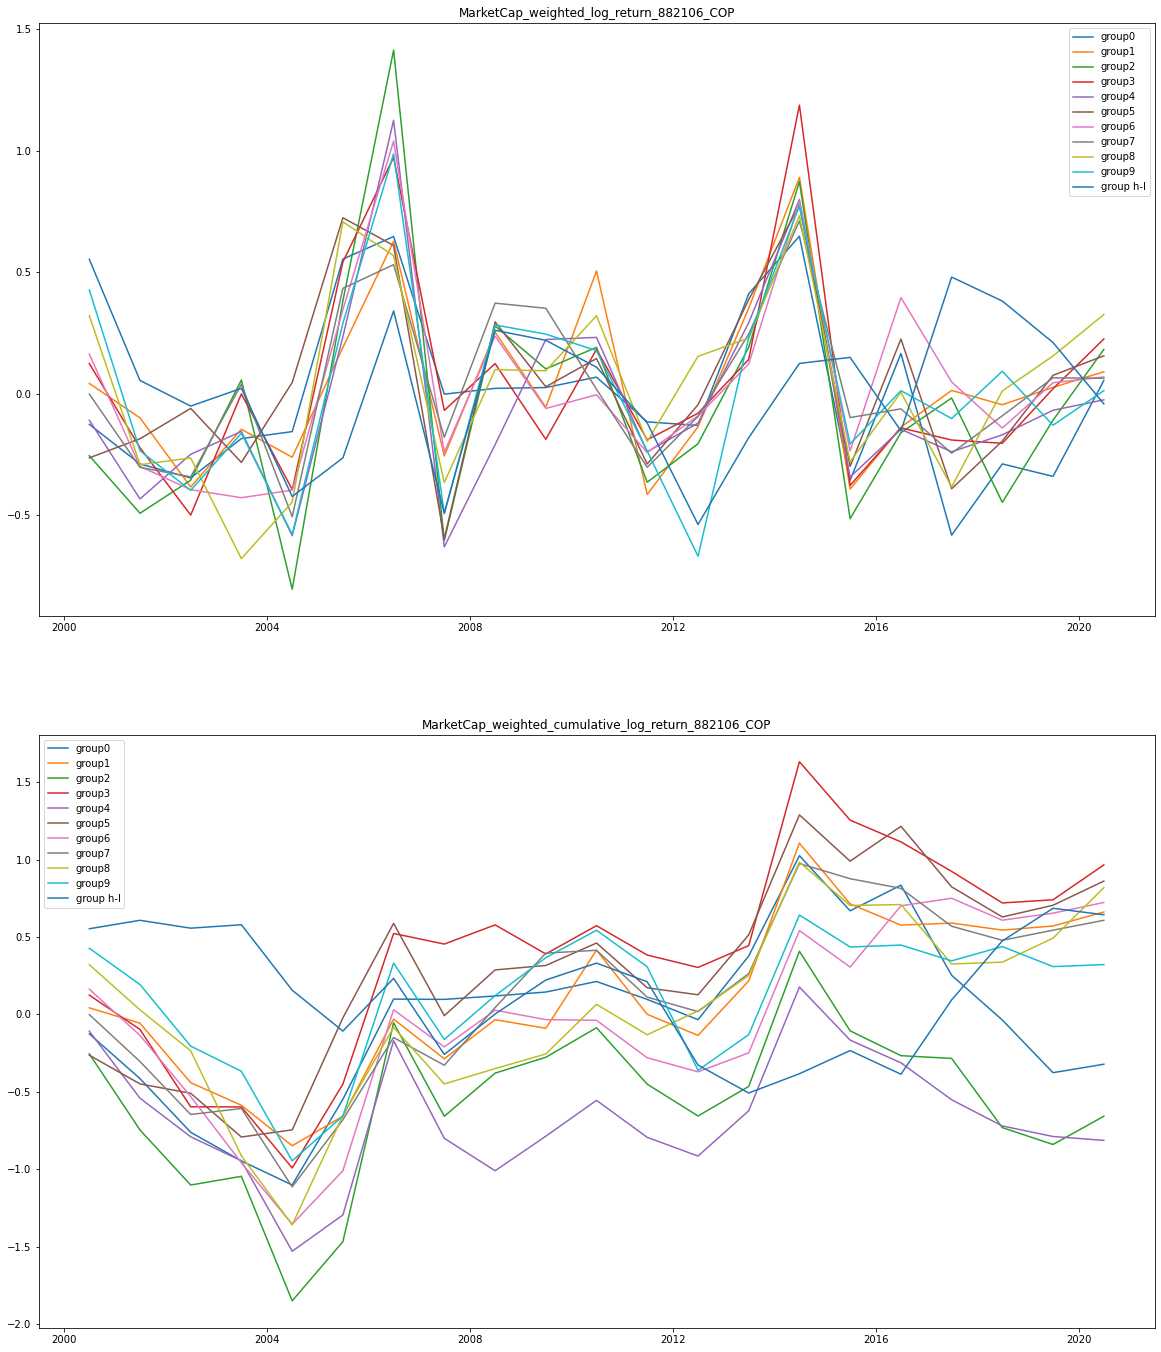

In [483]:
#882106 市值加权
ind_882106_test.MC_weight(ob_t = COP.index,tt='882106_COP')

TotalReturn AnnualReturn Sharpe        CAPM Alpha              Beta  \
0        1.0913       0.0376  0.066  [0.0076, 0.1615]  [0.9984, 6.5845]   
1        1.5555        0.048  0.289  [0.0216, 0.4635]   [0.8353, 5.549]   
2        1.4661       0.0462  0.204  [0.0175, 0.4013]   [0.925, 6.5897]   
3        2.1153       0.0585  0.378  [0.0304, 0.7749]  [0.8582, 6.7745]   
4        3.4927        0.078  0.414  [0.0466, 1.1098]  [0.9048, 6.6831]   
5        5.6565       0.0994  0.523  [0.0645, 1.5071]  [0.9343, 6.7699]   
6        1.5812       0.0486  0.239   [0.022, 0.4772]  [0.8399, 5.6528]   
7        3.1114       0.0732  0.418  [0.0446, 1.2547]   [0.825, 7.2016]   
8        2.0884        0.058  0.277  [0.0319, 0.8796]  [0.7898, 6.7498]   
9        6.1666       0.1035  0.632   [0.064, 1.3367]  [1.0787, 6.9831]   
h-l      2.4269       0.0635  0.666   [0.0564, 1.226]  [0.0803, 0.5411]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0506, -1.1455]  [-0.0187, -0.3169]       0.713  
1    [-0.0532, -0.9867]    [0.0605, 1.0144]       0.736  
2    [-0.0742, -1.6709]    [0.0326, 0.7836]       0.732  
3    [-0.0422, -0.9464]    [0.0391, 0.7756]       0.706  
4       [-0.039, -0.83]    [0.0448, 0.7937]        0.69  
5    [-0.0219, -0.5068]    [0.0689, 1.5123]       0.721  
6    [-0.0562, -1.0963]    [0.0403, 0.6965]       0.755  
7    [-0.0332, -1.0672]  [-0.0113, -0.2806]       0.637  
8    [-0.0326, -0.7642]    [0.0692, 1.6141]       0.572  
9    [-0.0187, -0.3249]    [0.0817, 1.3175]       0.669  
h-l    [0.0318, 0.5951]    [0.1004, 1.5011]        0.53

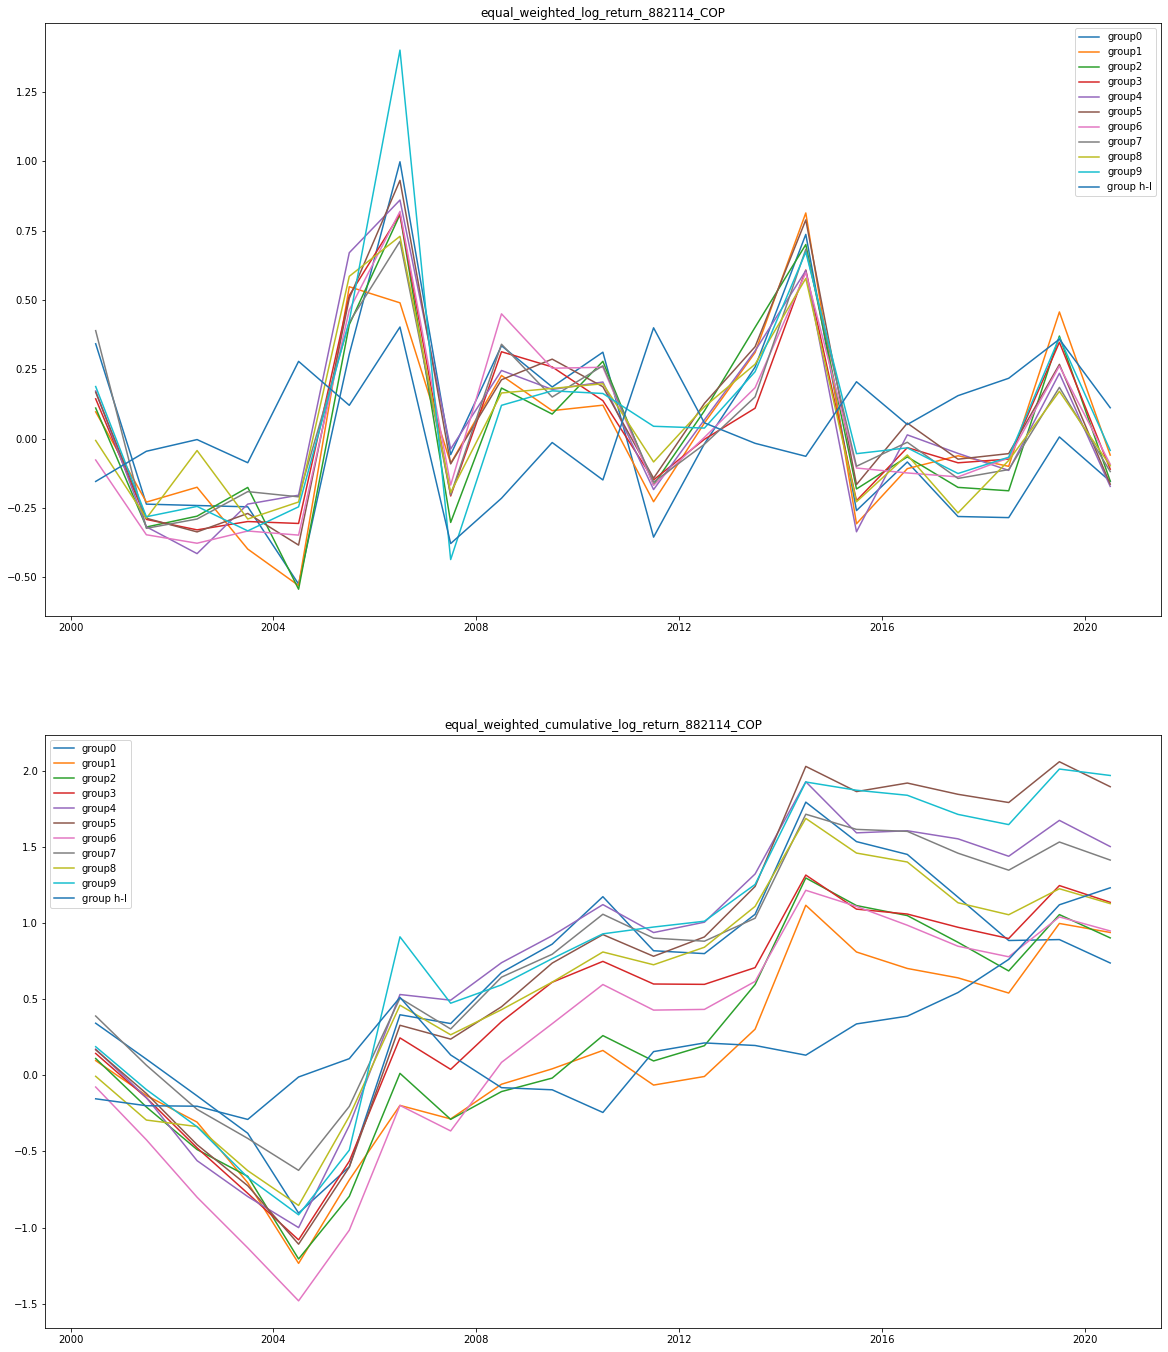

In [484]:
#882114 等值加权
ind_882114_test.E_weight(ob_t = COP.index,tt='882114_COP')

TotalReturn AnnualReturn Sharpe         CAPM Alpha              Beta  \
0       -0.5811      -0.0426 -0.617  [-0.0672, -1.116]    [0.935, 4.813]   
1        0.9187       0.0331  0.091   [0.0083, 0.1644]  [0.8242, 5.0655]   
2        1.4534       0.0459  0.208   [0.0192, 0.4013]   [0.852, 5.5112]   
3        2.2749       0.0611  0.446   [0.0327, 0.8618]  [0.8627, 7.0509]   
4        2.1439       0.0589  0.363   [0.0301, 0.6756]   [0.8863, 6.168]   
5        3.8667       0.0823  0.511   [0.0549, 1.1991]  [0.7423, 5.0292]   
6        1.3687       0.0441  0.215   [0.0173, 0.3117]  [0.8601, 4.7942]   
7        4.7528       0.0914  0.575   [0.0618, 1.5764]  [0.7784, 6.1517]   
8        1.8188       0.0532  0.271   [0.0286, 0.6376]  [0.7528, 5.2069]   
9         5.066       0.0943  0.796   [0.0557, 1.1463]  [1.0922, 6.9671]   
h-l     13.4803        0.143  1.049   [0.1229, 1.9766]  [0.1571, 0.7834]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0     [-0.1227, -1.604]  [-0.1512, -1.5244]       0.833  
1    [-0.0638, -1.0072]     [0.068, 0.9567]       0.747  
2    [-0.0552, -0.9548]      [0.0464, 0.89]        0.73  
3    [-0.0215, -0.4488]    [0.0454, 0.7798]       0.712  
4    [-0.0376, -0.6714]    [0.0104, 0.1373]        0.68  
5    [-0.0062, -0.1056]     [0.106, 1.5954]       0.683  
6    [-0.0168, -0.2228]     [0.0935, 1.014]       0.745  
7     [-0.014, -0.3132]    [0.0272, 0.4996]       0.545  
8      [0.0125, 0.2023]    [0.1101, 1.5582]       0.511  
9    [-0.0084, -0.1348]    [0.0809, 1.0903]        0.66  
h-l     [0.1142, 1.421]    [0.2322, 2.2826]       0.516

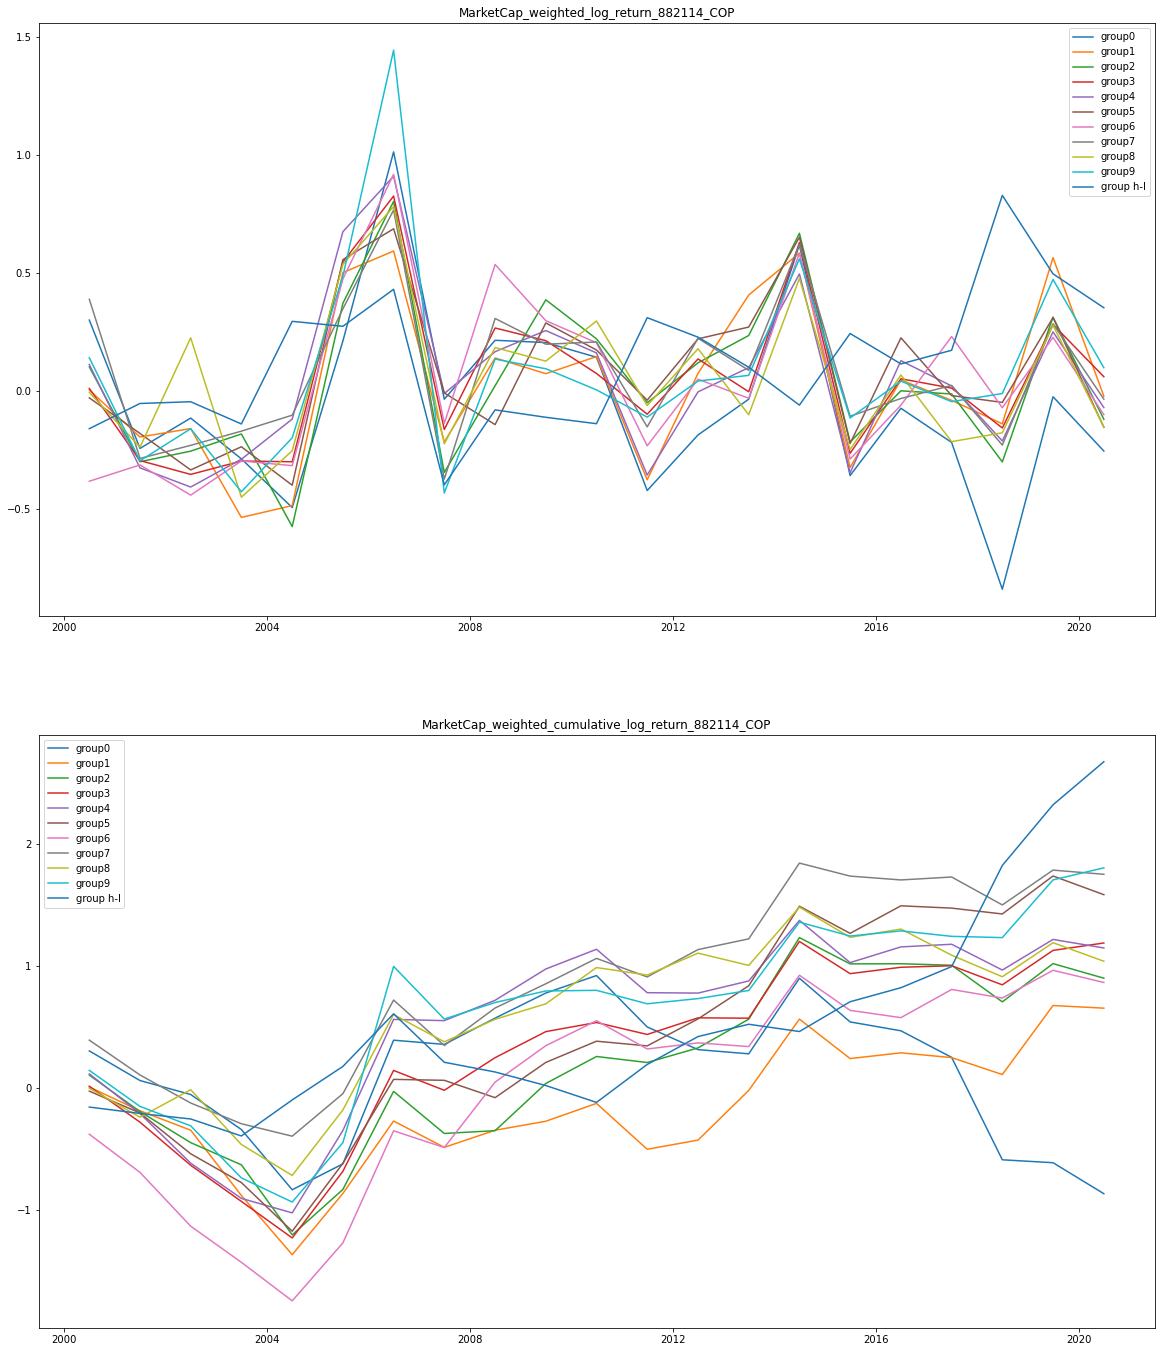

In [485]:
#882114 市值加权
ind_882114_test.MC_weight(ob_t = COP.index,tt='882114_COP')

TotalReturn AnnualReturn Sharpe          CAPM Alpha              Beta  \
0       -0.2768      -0.0161 -0.462   [-0.046, -0.9089]  [1.1097, 6.7929]   
1        2.4074       0.0632  0.304    [0.0266, 0.6784]  [1.1535, 9.1358]   
2        0.2082       0.0095 -0.271  [-0.0221, -0.5376]  [1.1263, 8.5084]   
3        1.4488       0.0458   0.16    [0.0098, 0.2428]  [1.1922, 9.1961]   
4       -0.1978       -0.011 -0.888  [-0.0347, -0.8899]  [0.8764, 6.9742]   
5       -0.2596      -0.0149 -1.091  [-0.0402, -1.1239]  [0.9378, 8.1333]   
6        -0.193      -0.0107 -0.487  [-0.0349, -0.8869]  [0.8967, 7.0564]   
7       -0.1386      -0.0074 -0.504  [-0.0357, -0.8824]  [1.0371, 7.9453]   
8         0.999       0.0352  0.065    [0.0075, 0.1446]  [0.9252, 5.5579]   
9        0.8833       0.0322  0.029   [-0.001, -0.0226]  [1.1295, 7.8108]   
h-l      1.6039        0.049  0.483     [0.045, 1.0684]  [0.0198, 0.1454]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.1568, -2.9299]  [-0.1109, -1.5411]       0.763  
1     [-0.0649, -1.566]  [-0.0001, -0.0013]       0.666  
2    [-0.1002, -2.2992]  [-0.0594, -1.0544]       0.745  
3    [-0.0641, -1.4012]  [-0.0183, -0.2984]        0.63  
4    [-0.0852, -1.8563]  [-0.0567, -0.9209]       0.677  
5    [-0.0909, -2.1318]  [-0.0492, -0.9404]       0.737  
6    [-0.0697, -1.5632]  [-0.0468, -0.7893]       0.723  
7    [-0.1148, -2.7558]   [-0.121, -2.0842]       0.709  
8    [-0.0789, -1.3437]   [-0.1055, -1.326]       0.673  
9    [-0.0704, -1.2935]   [-0.0773, -1.025]       0.646  
h-l    [0.0864, 1.5414]    [0.0337, 0.4613]       0.387

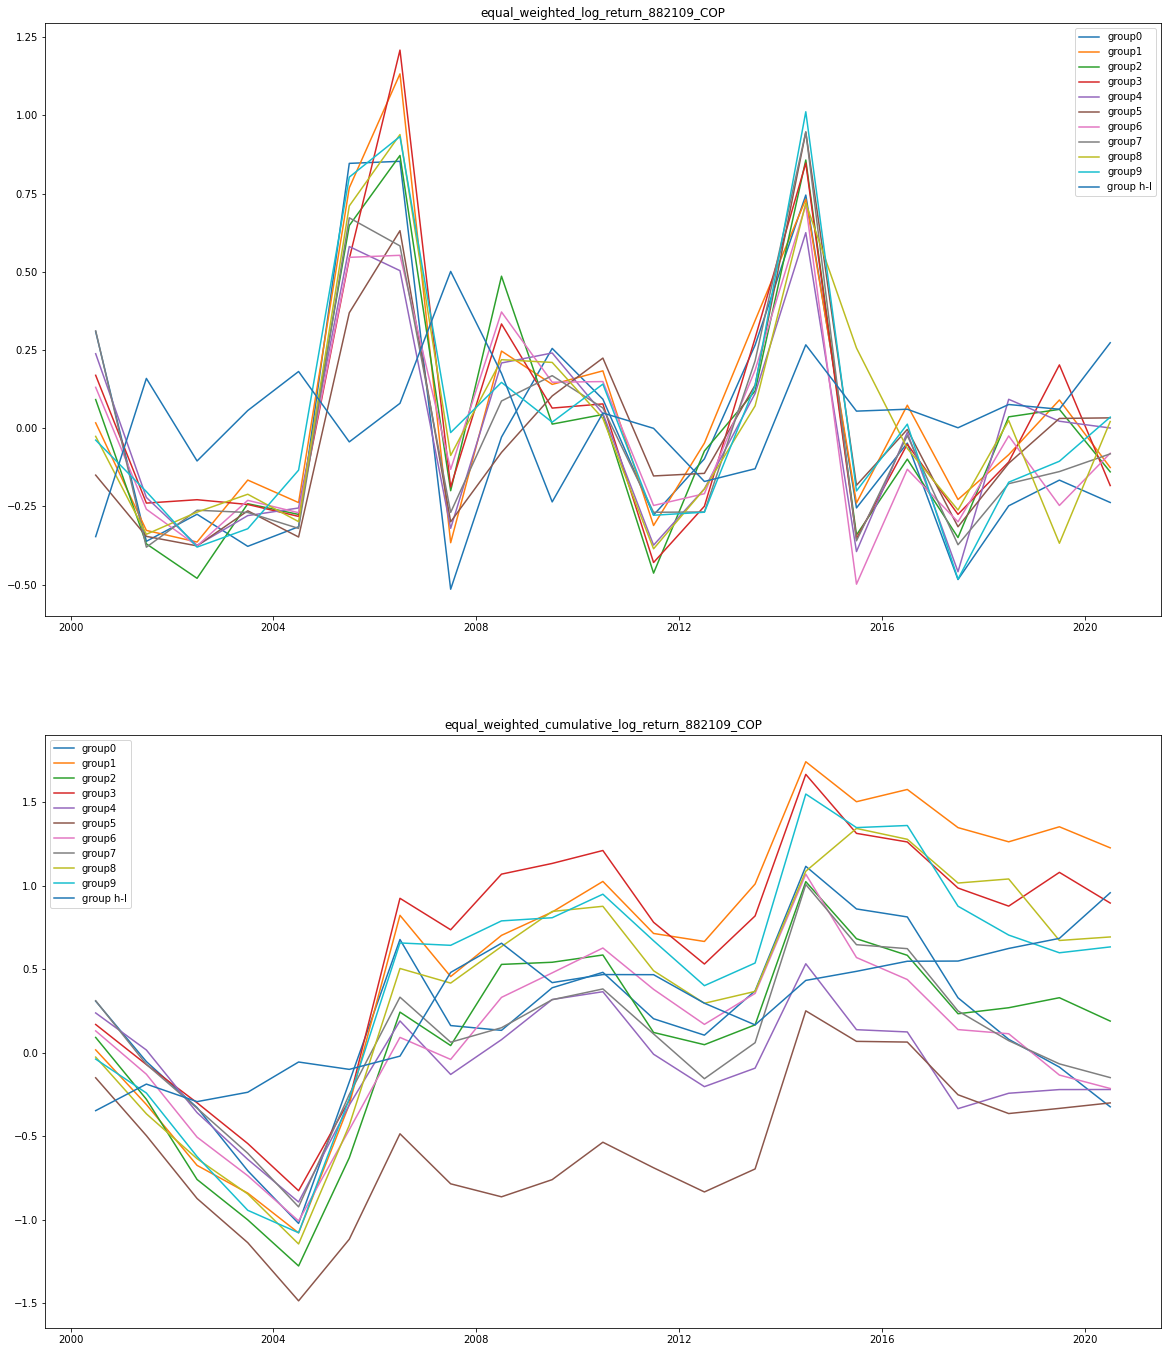

In [486]:
#882109 等值加权
ind_882109_test.E_weight(ob_t = COP.index,tt='882109_COP')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0       -0.2447      -0.0139 -0.391  [-0.0481, -0.8863]    [1.2592, 7.1946]   
1        1.2268       0.0408  0.138    [0.0042, 0.1063]    [1.2294, 9.6232]   
2        0.6864       0.0265 -0.033   [-0.0055, -0.127]    [1.1007, 7.9128]   
3       -0.0254      -0.0013 -0.642  [-0.0305, -0.7281]    [1.0619, 7.8557]   
4       -0.6185       -0.047 -1.487  [-0.0708, -1.6218]    [0.9049, 6.4229]   
5       -0.7067      -0.0595 -2.677  [-0.0836, -2.4074]    [0.9145, 8.1618]   
6       -0.3055      -0.0181 -0.493  [-0.0428, -1.0367]    [0.9223, 6.9263]   
7       -0.5371      -0.0378 -0.725    [-0.0658, -1.15]    [1.0549, 5.7193]   
8        0.1855       0.0085 -0.206  [-0.0232, -0.5757]    [1.1361, 8.7271]   
9        1.3017       0.0426  0.118     [0.005, 0.1114]    [1.2586, 8.7242]   
h-l      2.0474       0.0573  0.651    [0.0531, 1.1137]  [-0.0006, -0.0042]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.1482, -2.3141]  [-0.0846, -1.0125]       0.775  
1    [-0.0658, -1.4089]    [0.0118, 0.2046]       0.657  
2     [-0.092, -1.8766]  [-0.0436, -0.6784]       0.724  
3    [-0.1131, -2.3131]  [-0.0571, -0.8937]       0.658  
4    [-0.1134, -2.0115]  [-0.0934, -1.2016]       0.723  
5    [-0.0999, -2.1856]  [-0.0894, -1.5201]        0.73  
6    [-0.0821, -1.5681]  [-0.0791, -1.1212]       0.767  
7    [-0.1856, -2.8849]   [-0.1657, -1.852]       0.823  
8     [-0.069, -1.3073]  [-0.0657, -0.9152]        0.62  
9     [-0.0868, -1.692]  [-0.0827, -1.1605]       0.634  
h-l    [0.0614, 0.9465]    [0.0018, 0.0218]       0.453

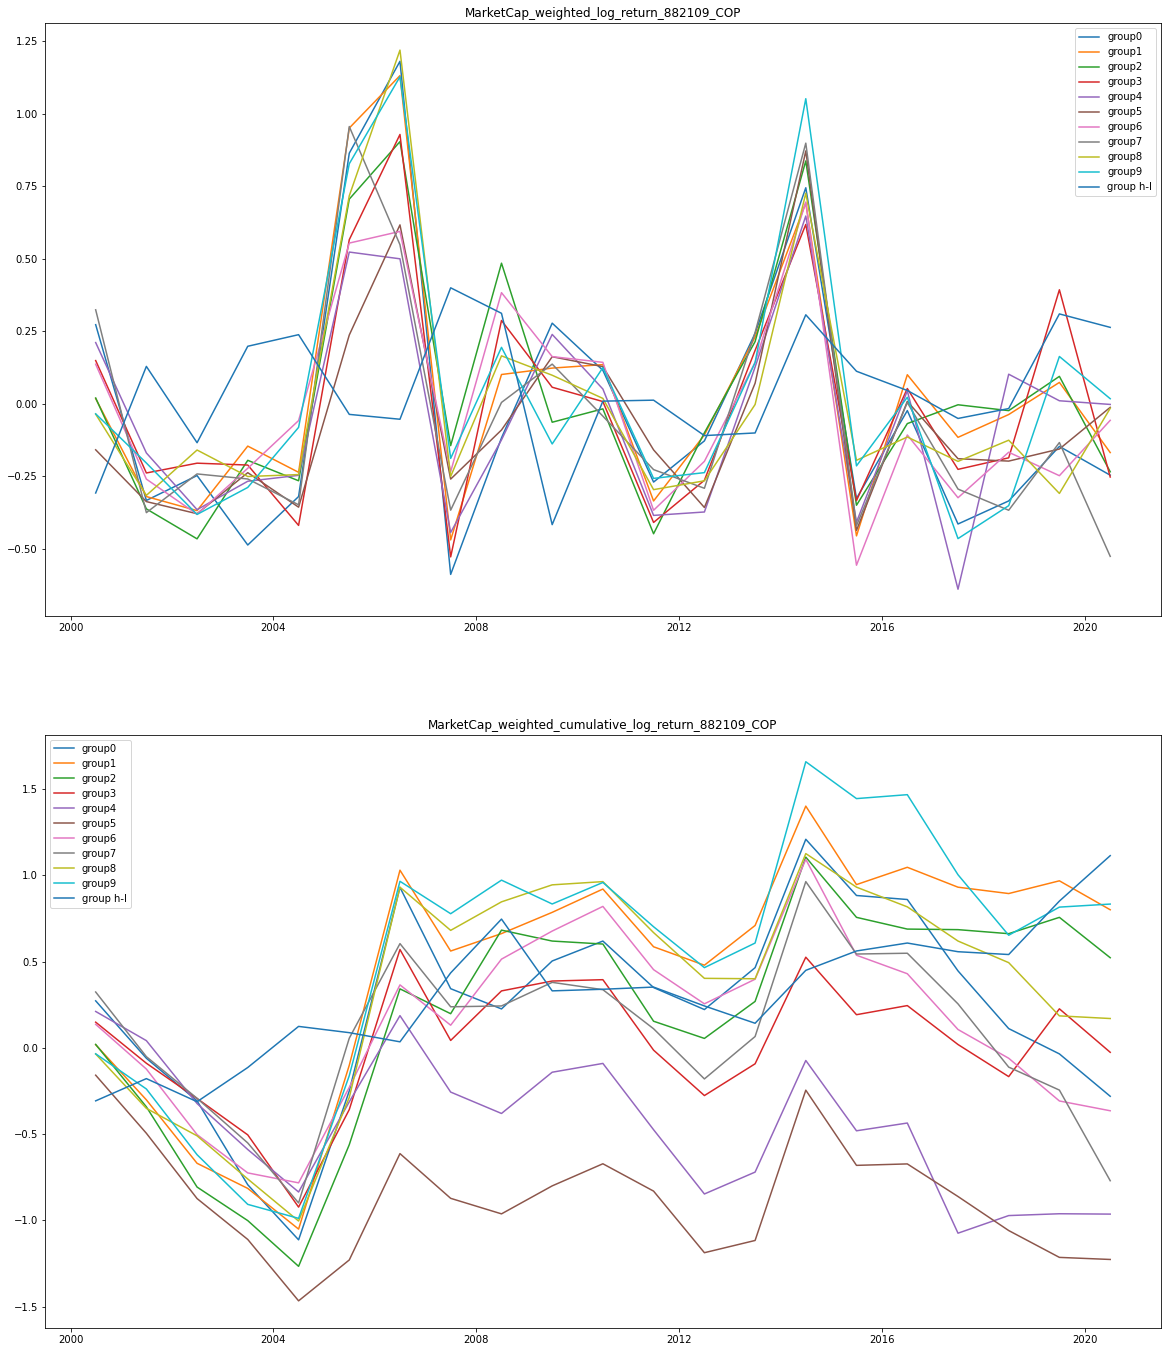

In [487]:
#882109 市值加权
ind_882109_test.MC_weight(ob_t = COP.index,tt='882109_COP')

mean         1.982531
mean(abs)    2.516290
std          2.607580
|t|>2        0.500000
dtype: float64


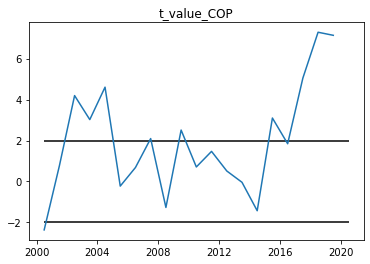

In [488]:
t_value = []
for i in ob_t:
    y = Re.loc[i,:].dropna()
    x = COP.loc[i,y.index]
    X = np.mat(np.stack([np.ones(shape=x.shape),x]).T)
    y = np.mat(y).T
    beta = (X.T*X).I*X.T*y
    u = y-X*beta

    #estimated variation of regression
    varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
    se = np.sqrt(np.diag(varbeta))

    #record estimation
    t_value.append((beta.T/se)[0,1])
t_value = pd.Series(t_value,index = ob_t)
plt.plot(t_value)
plt.title('t_value_COP')
plt.hlines(2,ob_t[0],ob_t[-1],colors='black')
plt.hlines(-2,ob_t[0],ob_t[-1],colors='black')
print(pd.Series({'mean':np. mean(t_value),'mean(abs)':np.mean(abs(t_value)),'std':np.std(t_value),'|t|>2':t_value[abs(t_value)>2].count()/t_value.count()}))        